<img src="https://s3-sa-east-1.amazonaws.com/preditiva.ai/diversos/preditiva_assinatura.jpg">

# Hands on: Validação de Modelos

A food company with over 20,000 employees across Brazil has noticed an increase in healthcare costs for its employees over the years. To understand this trend, the Benefits and Well-being management of the People Directorate conducted an internal survey with a randomly selected group of 1,338 employees over the course of a year.

The management believes that factors such as smoking and obesity may be related to increased healthcare usage, which in turn raises costs. Therefore, the survey respondents provided personal characteristics such as Body Mass Index (BMI), Number of Children, and whether they smoke. Below is the data dictionary:

### Data Dictionary

| Variable          | Description                                                                                   |
|-------------------|-----------------------------------------------------------------------------------------------|
| DtRef             | Reference Date when the survey with the employee was conducted                               |
| Age               | Employee's age                                                                                |
| Sex               | Employee's gender                                                                             |
| BMI               | Body Mass Index of the employee                                                              |
| Number_of_Children| Number of children the employee has                                                          |
| Smoker            | Flag indicating whether the employee is a smoker or non-smoker                                |
| Region            | Region of Brazil where the employee lives                                                     |
| Health_Cost       | Health Insurance Cost that this employee brought to the company 3 months after the Reference Date|

Based on this information, the following is requested:

- **Develop a model that estimates the healthcare costs of employees for the next 3 months**
- **Validate the model using Out-of-Sample, Out-of-Time, and Cross-Validation techniques**
- **What is your conclusion regarding the best type of validation for the problem? What is your estimate for the expected performance measure of the model when used to predict healthcare costs?**

## Importing the libraries

In [1]:
# Importing necessary libraries for data manipulation, visualization, and model training
import pandas as pd  # For data manipulation
import numpy as np   # For numerical operations
import matplotlib.pyplot as plt  # For plotting graphs
import seaborn as sns   # For enhanced visualization capabilities

# Importing the linear regression model from scikit-learn
from sklearn import linear_model  

# Importing performance metrics for evaluation
from sklearn.metrics import mean_squared_error, r2_score  

# Importing functions for data splitting and cross-validation
from sklearn.model_selection import train_test_split  # For splitting data into training and testing sets
from sklearn.model_selection import KFold  # For cross-validation

# Ignoring warnings to keep the output clean
import warnings
warnings.filterwarnings("ignore")

## Importing the dataset

In [2]:
# File name to be read:
data_file_name = 'base_custos_saude.xlsx'

# Target feature for prediction:
targetF = 'Custo_Saude'

In [3]:
#Importing the database
df = pd.read_excel(data_file_name)
df

,DtRef,Idade,Sexo,IMC,Qte_Filhos,Fumante,Regiao,Custo_Saude
0,202101,25,Masculino,26.220,0,Não,Nordeste,272.132080
1,202101,23,Masculino,17.385,1,Não,Norte,277.519215
2,202101,41,Masculino,21.780,1,Não,Sudeste,627.247720
3,202101,38,Masculino,37.050,1,Não,Nordeste,607.967150
4,202101,60,Feminino,24.530,0,Não,Sudeste,1262.989670
...,...,...,...,...,...,...,...,...
1333,202112,24,Masculino,31.065,0,Sim,Nordeste,3425.405335
1334,202112,43,Masculino,25.520,5,Não,Sudeste,1447.833015
1335,202112,19,Masculino,34.900,0,Sim,Centro,3482.865400
1336,202112,45,Masculino,30.360,0,Sim,Sudeste,6259.287309


### Initial Exploratory Data Analysis


In [4]:
df.dtypes

DtRef            int64
Idade            int64
Sexo            object
IMC            float64
Qte_Filhos       int64
Fumante         object
Regiao          object
Custo_Saude    float64
dtype: object

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   DtRef        1338 non-null   int64  
 1   Idade        1338 non-null   int64  
 2   Sexo         1338 non-null   object 
 3   IMC          1338 non-null   float64
 4   Qte_Filhos   1338 non-null   int64  
 5   Fumante      1338 non-null   object 
 6   Regiao       1338 non-null   object 
 7   Custo_Saude  1338 non-null   float64
dtypes: float64(2), int64(3), object(3)
memory usage: 83.8+ KB


In [6]:
df.describe()

,DtRef,Idade,IMC,Qte_Filhos,Custo_Saude
count,1338.000000,1338.000000,1338.000000,1338.000000,1338.000000
mean,202106.503737,39.207025,30.663397,1.094918,1327.042227
std,3.428562,14.049960,6.098187,1.205493,1211.001124
min,202101.000000,18.000000,15.960000,0.000000,112.187390
25%,202104.000000,27.000000,26.296250,0.000000,474.028715
50%,202106.000000,39.000000,30.400000,1.000000,938.203300
75%,202109.000000,51.000000,34.693750,2.000000,1663.991252
max,202112.000000,64.000000,53.130000,5.000000,6377.042801


In [7]:
df['DtRef'].value_counts().sort_index()

DtRef
202101    105
202102    112
202103    107
202104    122
202105    114
202106    117
202107    101
202108    115
202109    119
202110    102
202111    114
202112    110
Name: count, dtype: int64

In [8]:
df['DtRef'].value_counts()

DtRef
202104    122
202109    119
202106    117
202108    115
202105    114
202111    114
202102    112
202112    110
202103    107
202101    105
202110    102
202107    101
Name: count, dtype: int64

## Correlation Analysis

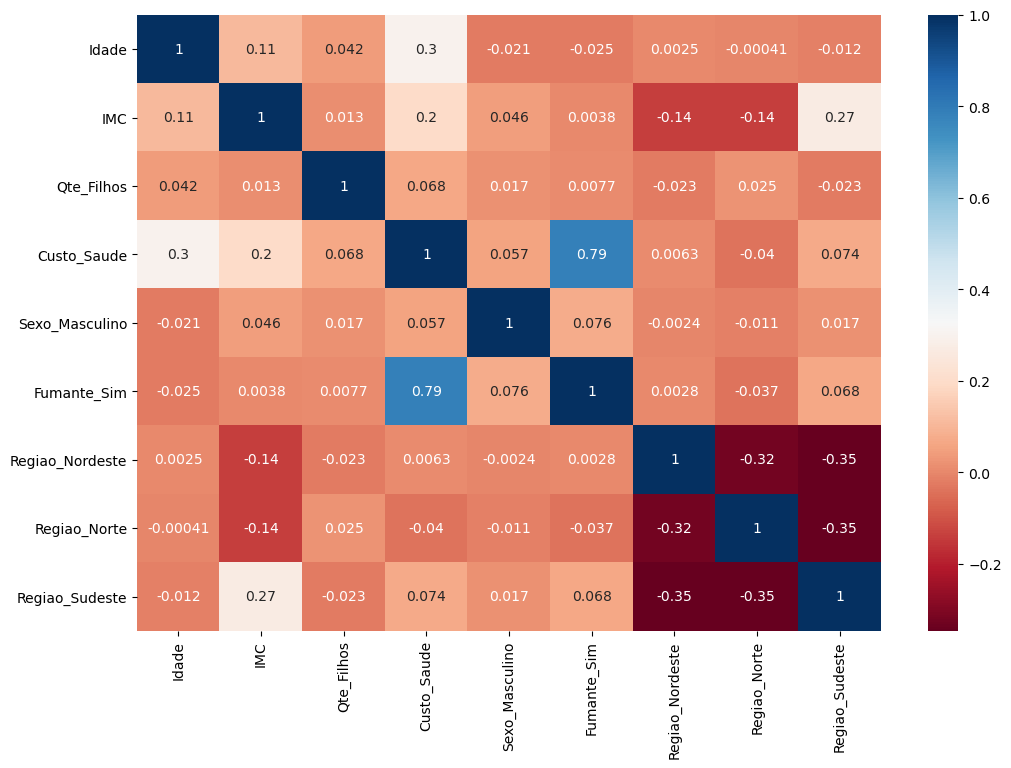

In [9]:
# Copy the original DataFrame to avoid unwanted modifications
df_encoded = df.copy()

# Convert categorical variables to dummy variables using one-hot encoding
# Keep only one dummy variable for each category by dropping the first one (avoiding multicollinearity)
df_encoded = pd.get_dummies(df_encoded, columns=['Sexo', 'Fumante', 'Regiao'], drop_first=True)

# Adjust the size of the figure
plt.figure(figsize=(12, 8))

# Remove the 'DtRef' column from the DataFrame to calculate correlations
correlation_matrix = df_encoded.drop('DtRef', axis=1).corr()

# Create the heatmap with correlations
sns.heatmap(correlation_matrix, cmap='RdBu', annot=True)

# Display the heatmap
plt.show()

In [10]:
# DataFrame containing encoded categorical variables using one-hot encoding
df_encoded

,DtRef,Idade,IMC,Qte_Filhos,Custo_Saude,Sexo_Masculino,Fumante_Sim,Regiao_Nordeste,Regiao_Norte,Regiao_Sudeste
0,202101,25,26.220,0,272.132080,True,False,True,False,False
1,202101,23,17.385,1,277.519215,True,False,False,True,False
2,202101,41,21.780,1,627.247720,True,False,False,False,True
3,202101,38,37.050,1,607.967150,True,False,True,False,False
4,202101,60,24.530,0,1262.989670,False,False,False,False,True
...,...,...,...,...,...,...,...,...,...,...
1333,202112,24,31.065,0,3425.405335,True,True,True,False,False
1334,202112,43,25.520,5,1447.833015,True,False,False,False,True
1335,202112,19,34.900,0,3482.865400,True,True,False,False,False
1336,202112,45,30.360,0,6259.287309,True,True,False,False,True


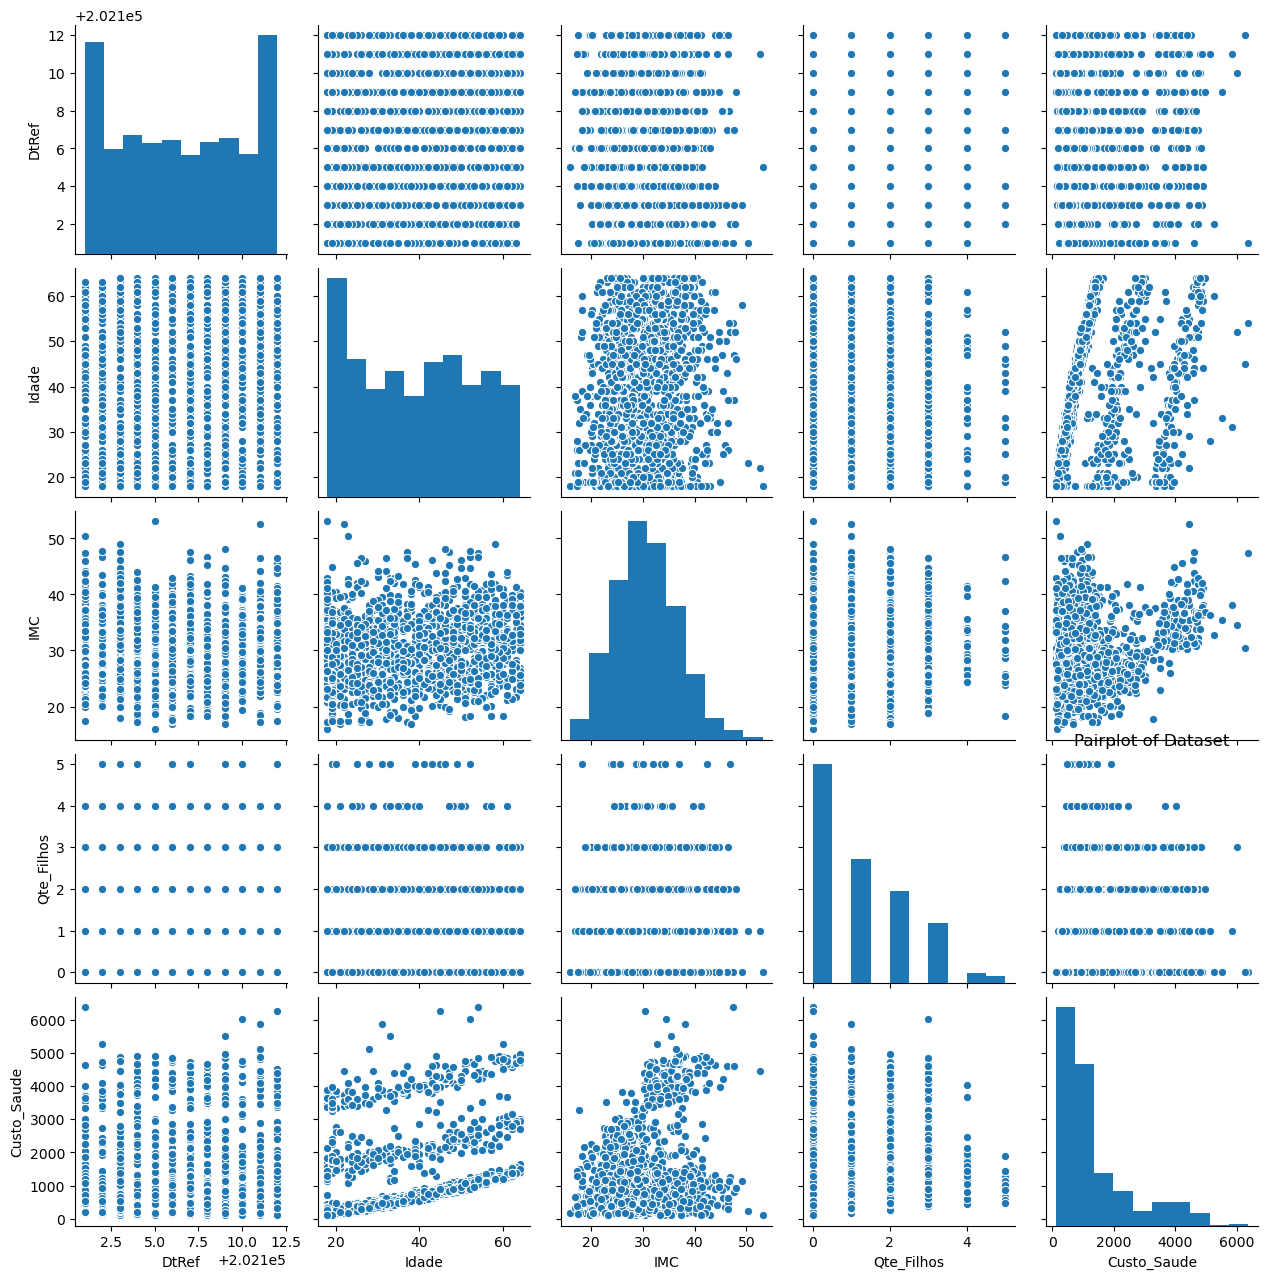

In [11]:
# Replace 'data' with your own data
# Make sure the DataFrame includes all the columns listed above
data = df

# Create the pairplot
sns.pairplot(data)

# Add title to the plot
plt.title('Pairplot of Dataset')

# Display the plot
plt.show()

Text(0.5, 1.0, 'Qte_Filhos x Custos')

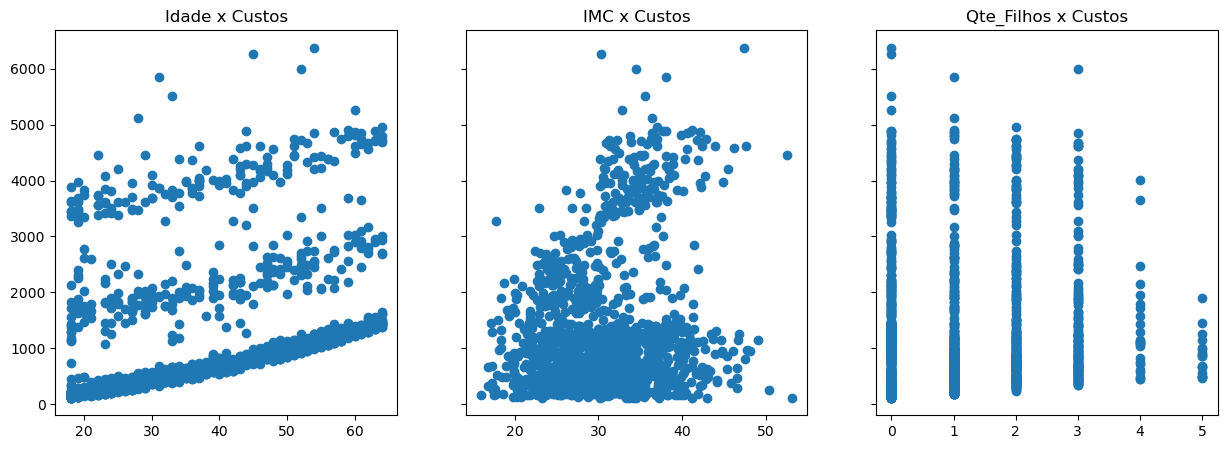

In [12]:
fig, ((ax1,ax2,ax3)) = plt.subplots(1,3,sharey=True,figsize=(15,5))
ax1.scatter(df['Idade'],df['Custo_Saude']);
ax1.set_title('Idade x Custos')

ax2.scatter(df['IMC'],df['Custo_Saude']);
ax2.set_title('IMC x Custos')

ax3.scatter(df['Qte_Filhos'],df['Custo_Saude']);
ax3.set_title('Qte_Filhos x Custos')

The health cost has little correlation with the numerical variables BMI (Body Mass Index) and Number of Children. Perhaps the qualitative variables may have more influence on health costs. We will see when running the model. The Age variable suggests a correlation. 
**Besides, there may be distinct groups with higher costs due to the dispersion's shape.**

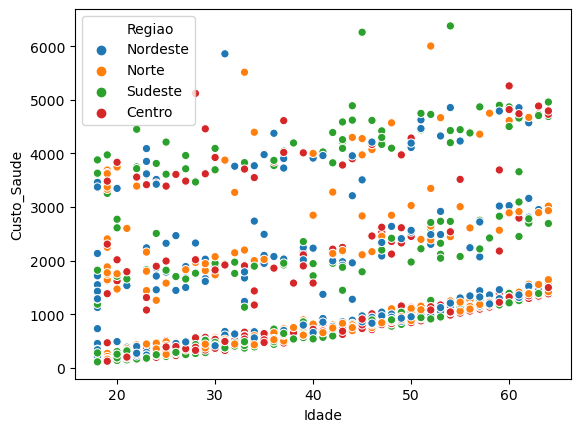

In [13]:
sns.scatterplot(df['Idade'],df['Custo_Saude'],hue = df['Regiao'] );

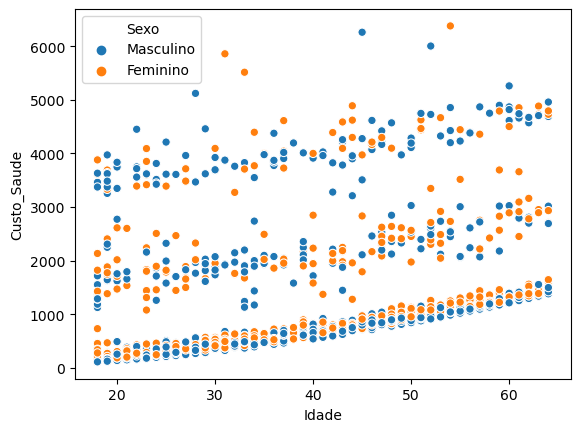

In [14]:
sns.scatterplot(df['Idade'],df['Custo_Saude'],hue = df['Sexo'] );

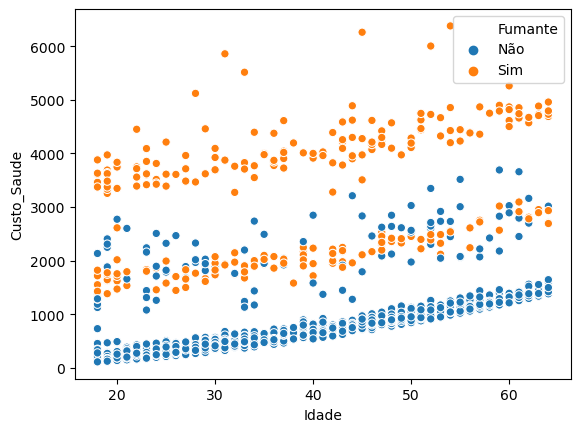

In [15]:
sns.scatterplot(df['Idade'],df['Custo_Saude'],hue = df['Fumante'] );

It seems like we've found an important relationship. **Smokers have a significantly higher health insurance cost compared to non-smokers.**

### Model Development

In [16]:
df.columns

Index(['DtRef', 'Idade', 'Sexo', 'IMC', 'Qte_Filhos', 'Fumante', 'Regiao',
       'Custo_Saude'],
      dtype='object')

In [17]:
x = df[['Idade', 'Sexo', 'IMC', 'Qte_Filhos', 'Fumante', 'Regiao']]
y = df['Custo_Saude']

In [18]:
# Convert categorical variables to dummy variables using one-hot encoding
# Remove one dummy variable for each category to prevent multicollinearity in linear regression
x = pd.get_dummies(x, drop_first=True)

In [19]:
x

,Idade,IMC,Qte_Filhos,Sexo_Masculino,Fumante_Sim,Regiao_Nordeste,Regiao_Norte,Regiao_Sudeste
0,25,26.220,0,True,False,True,False,False
1,23,17.385,1,True,False,False,True,False
2,41,21.780,1,True,False,False,False,True
3,38,37.050,1,True,False,True,False,False
4,60,24.530,0,False,False,False,False,True
...,...,...,...,...,...,...,...,...
1333,24,31.065,0,True,True,True,False,False
1334,43,25.520,5,True,False,False,False,True
1335,19,34.900,0,True,True,False,False,False
1336,45,30.360,0,True,True,False,False,True


### Out-of-Sample Validation

In [20]:
# Split the dataset into 70% for Training and 30% for Testing
X_train, X_test, y_train, y_test = train_test_split(x, y, 
                                                    test_size=0.30,
                                                    random_state=50)

In [21]:
# Instantiate the linear regression model with intercept
modelo = linear_model.LinearRegression(fit_intercept=True)

# Fit the model to the training data
modelo.fit(X_train, y_train)

LinearRegression()

In [22]:
# Create a DataFrame to display the coefficients (Betas) of the model
pd.DataFrame({'Variables': X_train.columns, 'Coefficients': modelo.coef_})

,Variables,Coefficients
0,Idade,24.718403
1,IMC,33.669597
2,Qte_Filhos,58.957392
3,Sexo_Masculino,-26.682137
4,Fumante_Sim,2389.734268
5,Regiao_Nordeste,43.389732
6,Regiao_Norte,51.983317
7,Regiao_Sudeste,-54.283788


In [23]:
# Calculate R2 score on Training data
predicted_costs_train = modelo.predict(X_train)
r2_train = r2_score(y_train, predicted_costs_train)

# Calculate R2 score on Testing data
predicted_costs_test = modelo.predict(X_test)
r2_test = r2_score(y_test, predicted_costs_test)

# Create a DataFrame to display R2 scores
pd.DataFrame({'R2 on Training': [r2_train], 'R2 on Testing': [r2_test]})

,R2 on Training,R2 on Testing
0,0.75165,0.74665


### Cross-Validation - K-Fold

In [24]:
# Define K-Fold cross-validation with 5 folds, shuffling the data, and setting a random seed for reproducibility
partitions = KFold(n_splits=5, shuffle=True, random_state=777)

In [25]:
r2_train = []
r2_test = []

# Iterate over each fold in the K-Fold cross-validation
for train_index, test_index in partitions.split(x):
    
    # Split the dataset into train and test sets for this fold
    X_train, X_test = x.iloc[train_index], x.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    # Instantiate and train the model
    modelo = linear_model.LinearRegression(fit_intercept=True)
    modelo.fit(X_train, y_train)
    
    # Calculate R2 score on Training data
    predicted_costs_train = modelo.predict(X_train)
    r2_train.append(r2_score(y_train, predicted_costs_train))

    # Calculate R2 score on Testing data
    predicted_costs_test = modelo.predict(X_test)
    r2_test.append(r2_score(y_test, predicted_costs_test))
    
# Create a DataFrame to display R2 scores for each fold
resultado = pd.DataFrame({"R2 on Training": r2_train, "R2 on Testing": r2_test})
resultado

,R2 on Training,R2 on Testing
0,0.750443,0.748657
1,0.739728,0.790991
2,0.751636,0.743965
3,0.769028,0.664211
4,0.745558,0.772060


In [26]:
# Calculate and display the mean and standard deviation of R2 scores for both training and testing sets
resultado.describe().loc[['mean', 'std']]

,R2 on Training,R2 on Testing
mean,0.751279,0.743977
std,0.010977,0.048434


### Out-of-Time Validation

In [27]:
# Display the counts of unique values in the 'DtRef' column, sorted by index
df['DtRef'].value_counts().sort_index()

DtRef
202101    105
202102    112
202103    107
202104    122
202105    114
202106    117
202107    101
202108    115
202109    119
202110    102
202111    114
202112    110
Name: count, dtype: int64

As we have one year of data, let's split 70% of the year as training data and the remaining 30% as testing data.

In [28]:
# Therefore, let's split the months from 202101 to 202108 as training data and the rest as testing data.

In [29]:
# Convert categorical variables to dummy variables using one-hot encoding and drop the first category to avoid multicollinearity
df_dummies = pd.get_dummies(df, drop_first=True)

In [30]:
# Split the dataset into training and testing sets based on the 'DtRef' column
# Training set includes months up to and including 202108
# Testing set includes months after 202108
df_train = df_dummies[df_dummies['DtRef'] <= 202108].copy()
df_test = df_dummies[df_dummies['DtRef'] > 202108].copy()

In [31]:
# Prepare training and testing sets
X_train = df_train.drop(['Custo_Saude', 'DtRef'], axis=1)
y_train = df_train['Custo_Saude']

X_test = df_test.drop(['Custo_Saude', 'DtRef'], axis=1)
y_test = df_test['Custo_Saude']

In [32]:
# Instantiate the linear regression model with intercept
modelo = linear_model.LinearRegression(fit_intercept=True)

# Fit the model to the training data
modelo.fit(X_train, y_train)

LinearRegression()

In [33]:
# Create a DataFrame to display the coefficients (Betas) of the model
pd.DataFrame({'Variables': X_train.columns, 'Coefficients': modelo.coef_})

,Variables,Coefficients
0,Idade,25.142540
1,IMC,31.804968
2,Qte_Filhos,48.894520
3,Sexo_Masculino,-34.764725
4,Fumante_Sim,2282.573503
5,Regiao_Nordeste,94.925033
6,Regiao_Norte,92.486954
7,Regiao_Sudeste,-5.951687


In [34]:
# Calculate R2 score on Training data
predicted_costs_train = modelo.predict(X_train)
r2_train = r2_score(y_train, predicted_costs_train)

# Calculate R2 score on Testing data
predicted_costs_test = modelo.predict(X_test)
r2_test = r2_score(y_test, predicted_costs_test)

# Create a DataFrame to display R2 scores
pd.DataFrame({'R2 on Training': [r2_train], 'R2 on Testing': [r2_test]})

,R2 on Training,R2 on Testing
0,0.730722,0.780252


#### Out-of-Time Validation - Tracking R2 Over Time

In [35]:
# Predict health costs for all data points using the trained model
df_dummies['Predicted_Health_Costs'] = modelo.predict(df_dummies.drop(['Custo_Saude', 'DtRef'], axis=1))

In [36]:
# Calculate R2 score for each year-month combination
r2_per_year_month = {}

for year_month in df['DtRef'].unique():
    df_year_month = df_dummies[df_dummies['DtRef'] == year_month]
    r2 = r2_score(df_year_month['Custo_Saude'], df_year_month['Predicted_Health_Costs'])
    r2_per_year_month.update({year_month: r2})

# Create a DataFrame to display R2 scores for each year-month combination
df_r2_per_year_month = pd.DataFrame(r2_per_year_month, [0]).T.rename(columns={0: 'R2'})

In [37]:
df_r2_per_year_month

,R2
202101,0.685620
202102,0.769540
202103,0.670654
202104,0.706893
202105,0.724774
202106,0.807934
202107,0.673710
202108,0.770771
202109,0.783540
202110,0.780874


Text(0.5, 0, 'Month of 2021')

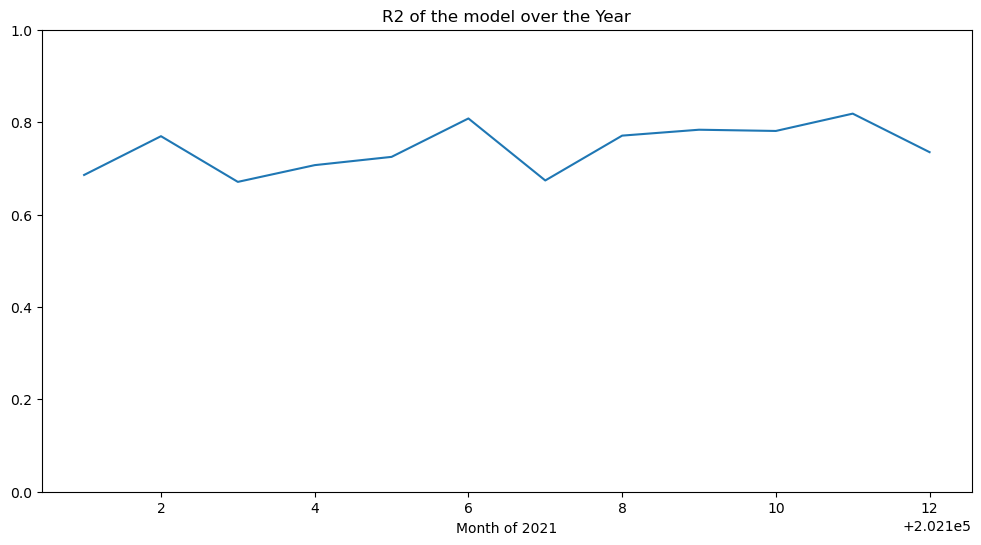

In [38]:
# Plot the R2 score of the model over the year
plt.figure(figsize=(12, 6))
plt.plot(df_r2_per_year_month['R2'])
plt.ylim(bottom=0, top=1)

plt.title("R2 of the model over the Year")
plt.xlabel("Month of 2021")

In [39]:
# Transpose the DataFrame to display R2 scores for each year-month combination
df_r2_per_year_month.T

,202101,202102,202103,202104,202105,202106,202107,202108,202109,202110,202111,202112
R2,0.68562,0.76954,0.670654,0.706893,0.724774,0.807934,0.67371,0.770771,0.78354,0.780874,0.818386,0.734972


### In conclusion, what is the best validation method for this problem, and what is the overall R2 of the model ?

Comparing the results of Cross-Validation and Out-of-Time Validation:

In [40]:
# Cross-Validation with k-fold = 5
resultado

,R2 on Training,R2 on Testing
0,0.750443,0.748657
1,0.739728,0.790991
2,0.751636,0.743965
3,0.769028,0.664211
4,0.745558,0.772060


In [41]:
# Out-of-Time Validation (training up to 202108 and testing from 202109 to 202112)
pd.DataFrame({'R2 on Training': r2_train, 'R2 on Testing': r2_test}, [0])

,R2 on Training,R2 on Testing
0,0.730722,0.780252
